<a href="https://colab.research.google.com/github/AbrahamOtero/MLiB/blob/main/4_5_IssuesTrainingNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## The MNIST dataset
To begin, let's load the MNIST dataset. Keras provides several functions for accessing popular datasets in tf.keras.datasets. The dataset is pre-split into a training set (60,000 grayscale images, each 28x28 pixels) and a test set (10,000 images).

In [ ]:
from keras.datasets import mnist

# Loading the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Each image is 28x28 pixels
X_train.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [ ]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.o

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

We can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

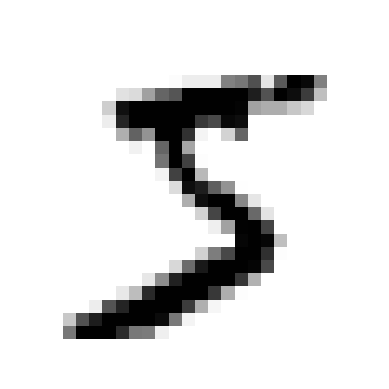

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are integers from 0 to 9:

In [ ]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Let's plot the first 40 elements of the dataset:

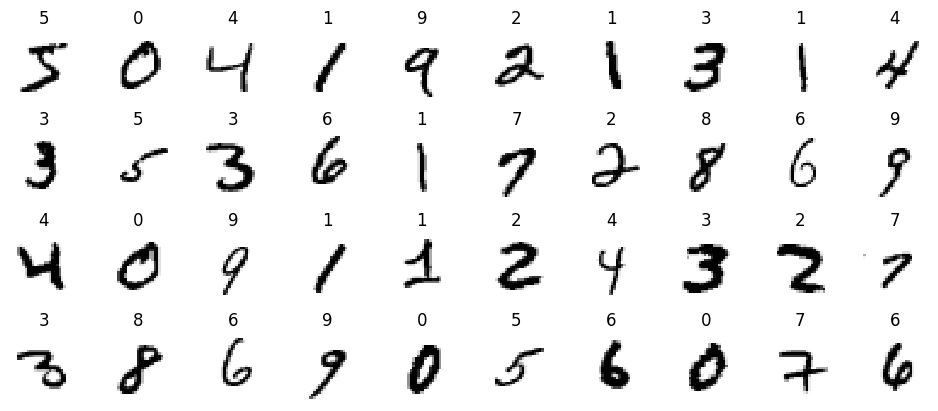

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# Gradient Vanishing Example

We will create a deep neural network with 8 layers adn with 128 neurons in each layer:

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from keras import optimizers

# Converts a class vector (integers) to binary class matrix.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the neural network
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # Flattens the input turning  a 28x28 matrix into a 784 vector
#We use the sigmoidal activation function. It is particularly bad for the reasons explained in theory.
for i in range(8):
  model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

#summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,354 (849.04 KB)

 Trainable params: 217,354 (849.04 KB)

 Non-trainable params: 0 (0.00 B)

Now we will proceed to training. Before training, we have collected the average value of the weights of each layer in a list. These weights have been initialized randomly. After training, we will collect the weights again, and show in a bar chart the difference between the initial and final weights.

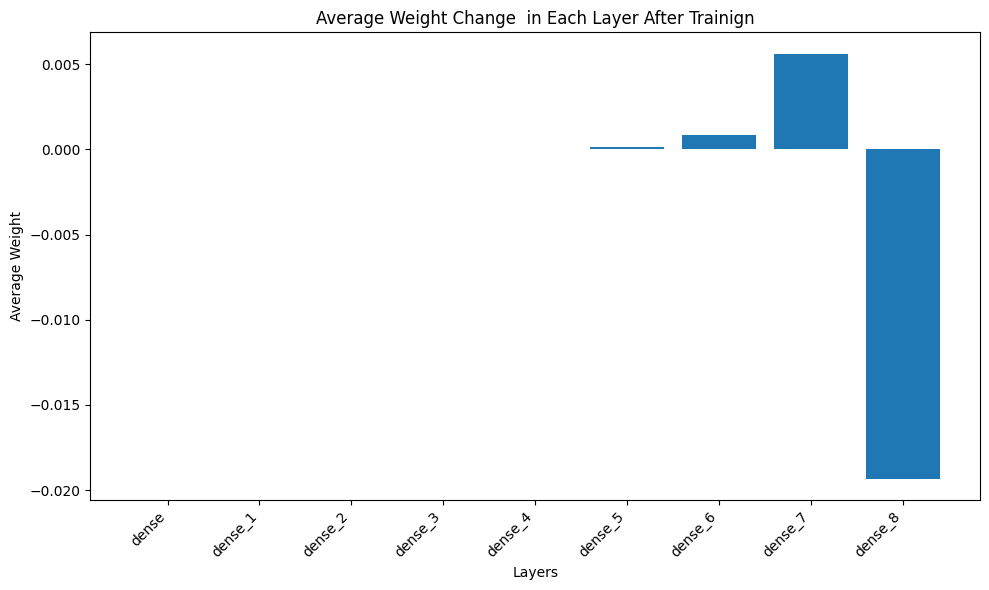

In [ ]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=0.1)  # Use stochastic gradient descent
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# We collect the initial weights of each layer (randomly initialized) before training
average_weights_ini = []
layer_names = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    layer_names.append(layer.name)
    #ignore the biases
    weights = weights[0]
    average_weights_ini.append(np.mean(np.abs(weights)))

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# We collect the weights after training
average_weights = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    #ignore the biases
    weights = weights[0]
    average_weights.append(np.mean(np.abs(weights)))

# We plot the difference between the weights before and after training
diff_weights = [w1 - w2 for w1, w2 in zip(average_weights, average_weights_ini)]

plt.figure(figsize=(10, 6))
plt.bar(layer_names, diff_weights)
plt.xlabel("Layers")
plt.ylabel("Average Weight")
plt.title("Average Weight Change  in Each Layer After Trainign")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

It can be observed that the gradient has been fading away; the last layer has seen its weights altered a little. The previous three layers have changed to a much lesser extent. But the first 5 layers have not changed at all. In this situation, it is obvious that the network has not learned. Let's see what the loss and the training and validation accuracy have been:

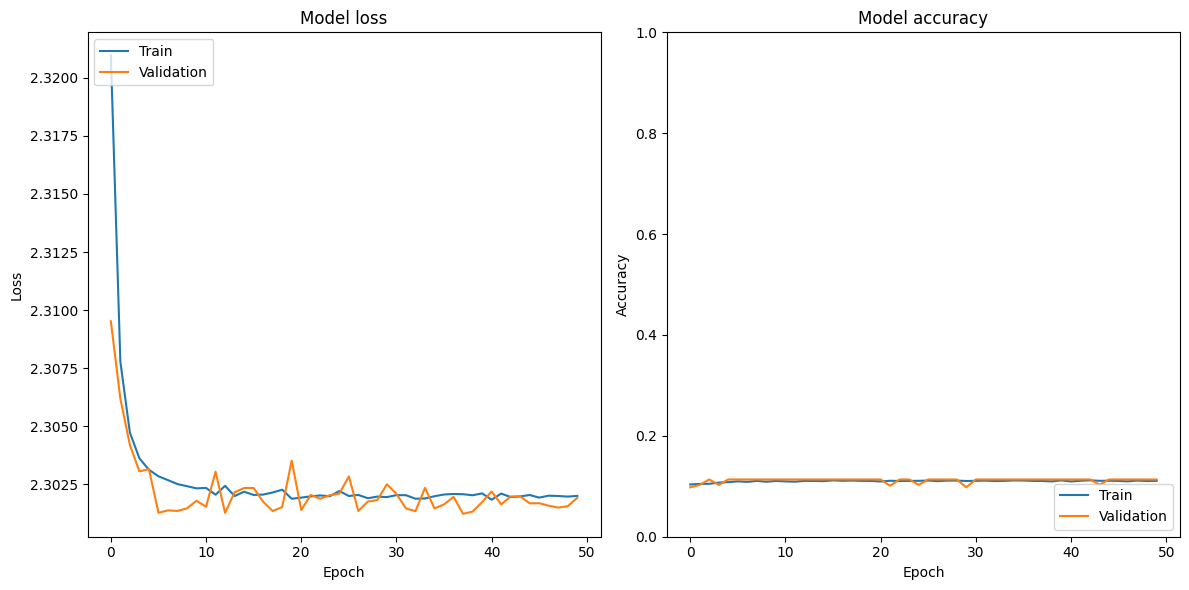

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

We can see that the model has not learned anything (don't be fooled by the shape of the loss function; look at the scale of the y-axis).

## Fixing the problem

Instead of using the sigmoidal function (which has a non-zero average value, in addition to being able to saturate the gradient for both small and high values) we use the elu function, whose gradient is constant for positive values:


In [ ]:
# Define the neural network
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # Flattens the input turning  a 28x28 matrix into a 784 vector
#We use the elu activation function.
for i in range(8):
  model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

#summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,354 (849.04 KB)

 Trainable params: 217,354 (849.04 KB)

 Non-trainable params: 0 (0.00 B)

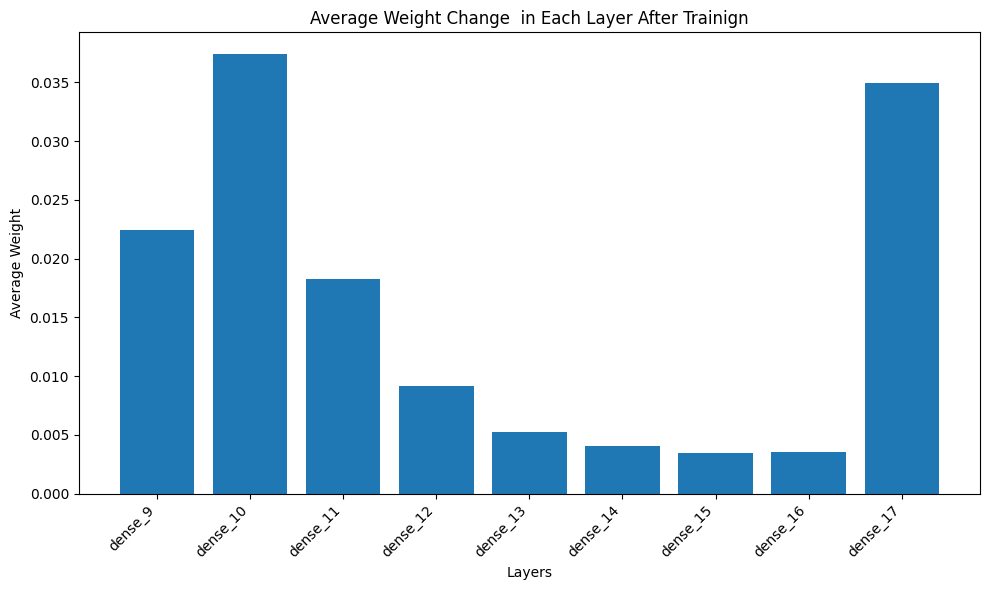

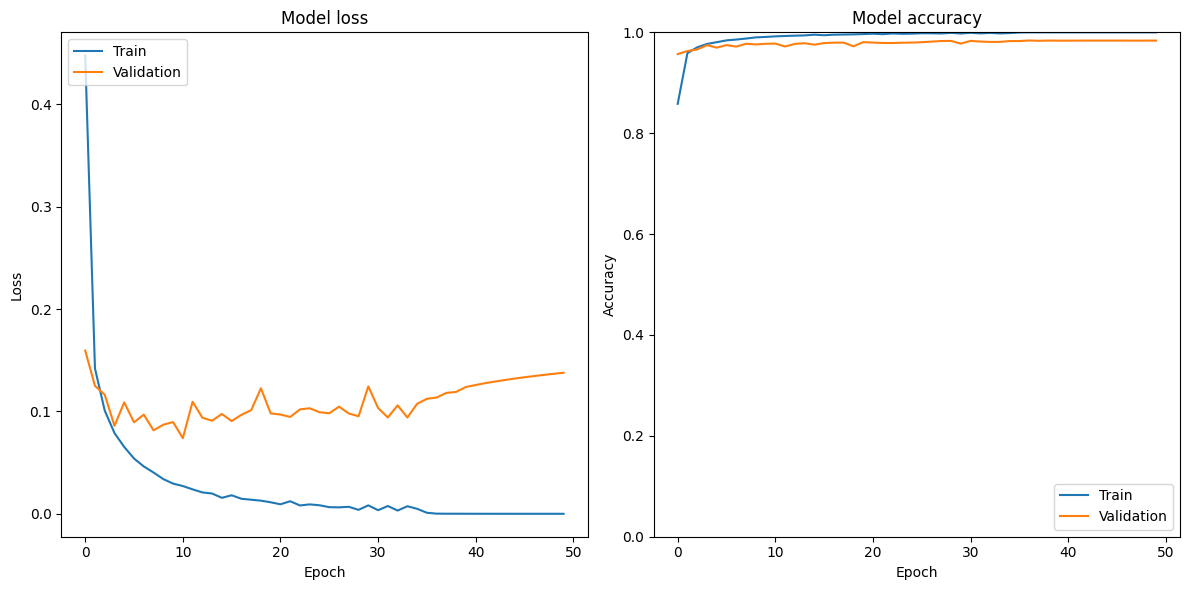

In [ ]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=0.1)  # Use stochastic gradient descent
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# We collect the initial weights of each layer (randomly initialized) before training
average_weights_ini = []
layer_names = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    layer_names.append(layer.name)
    #ignore the biases
    weights = weights[0]
    average_weights_ini.append(np.mean(np.abs(weights)))

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# We collect the weights after training
average_weights = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    #ignore the biases
    weights = weights[0]
    average_weights.append(np.mean(np.abs(weights)))

# We plot the difference between the weights before and after training
diff_weights = [w1 - w2 for w1, w2 in zip(average_weights, average_weights_ini)]

plt.figure(figsize=(10, 6))
plt.bar(layer_names, diff_weights)
plt.xlabel("Layers")
plt.ylabel("Average Weight")
plt.title("Average Weight Change  in Each Layer After Trainign")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


Now we have managed to learn something (although look at the shape of the loss functions; there is probably some overtraining).

# Unestable gradientes


Let's see what happens if we try to train the network in the previous example on the iris data set (it is excessively complex for this dataset, but we will do it for illustrative purposes).




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


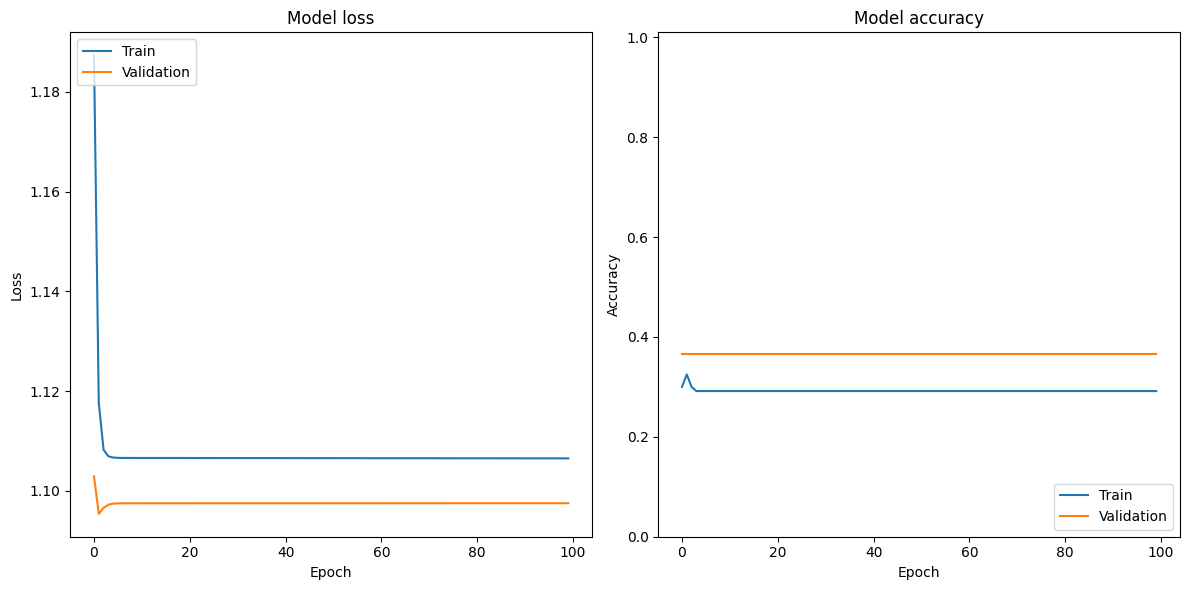

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

# Loading the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Encode class labels in one-hot format
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

tf.random.set_seed(42)

# Split the data into training and test sets and standarize the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the neural network (same architecture as before)
# It is excessively complex for a problem with 4 features and 150 data, but we do it for illustrative purposes.
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(4,)))
for i in range(8):
  model.add(Dense(100, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las 3 clases de Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


We have not managed to learn anything useful (the accuracy is around 1/3, which is what we would expect to get by random).

Note how if we had used a single layer, but with the same activation function size, we would have achieved a more or less reasonable training (and given the shape of the loss curves the training would probably benefit from continuing for more epochs):

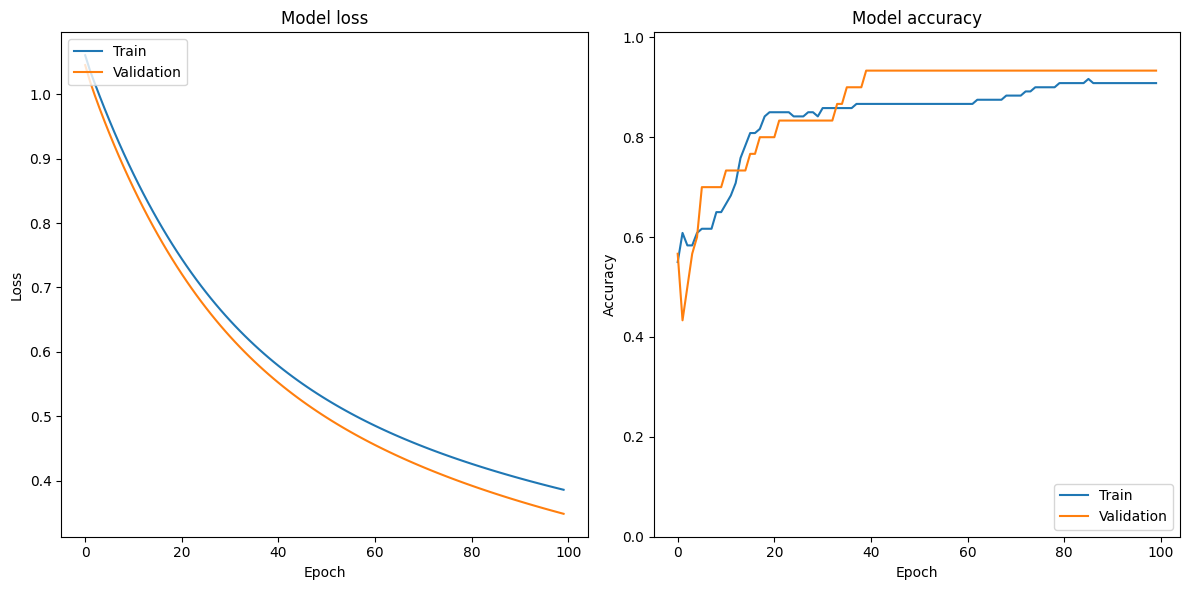

In [ ]:
# Define the neural network (same architecture as before)
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(4,)))
model.add(Dense(3, activation='softmax'))  # 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

Note that if we use 8 layers and 128 neurons, as originally, but if we use a better activation function, the training is more reasonable.

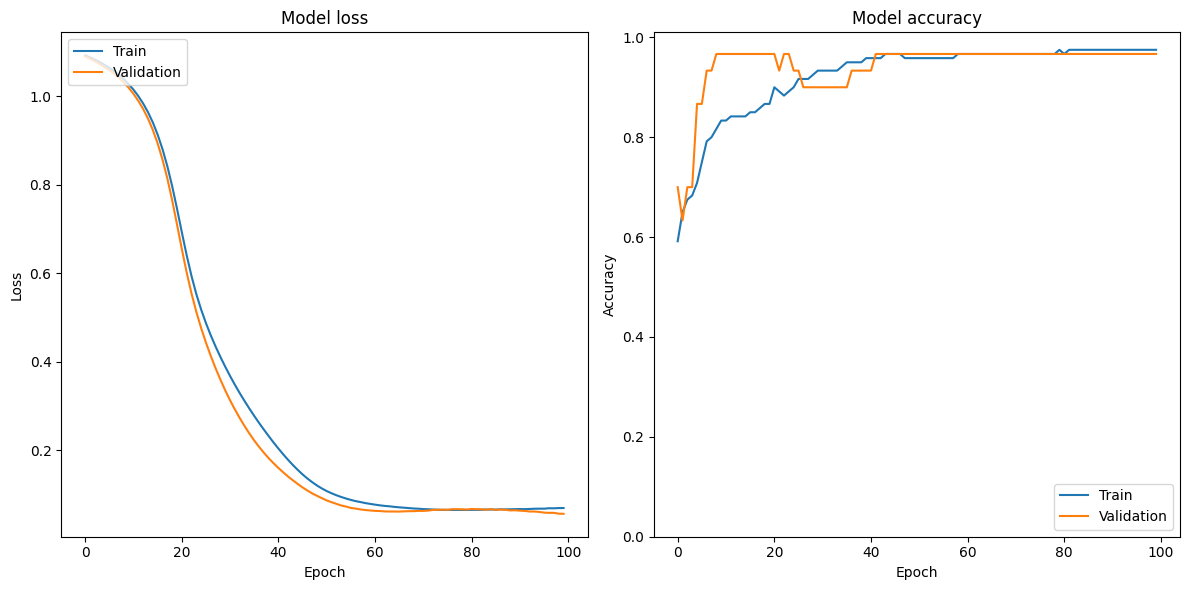

In [ ]:
# Define the neural network (same architecture as before)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(4,)))
for i in range(8):
  model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


Although we have now managed to learn something, look at the strong oscillations in the loss and accuracy curves. This could be due to instability in the gradients. One of the advances in neural networks has been the use of more sophisticated optimizers that employ more advanced techniques to control the the gradients.

We shall use one of these optimizerds: Adam. Without having to change the learning rate (in the previous examples I had to use 0.01 to get more reasonable results; if you change it it will probably get worse) we get a much faster convergence (about 20 epochs)

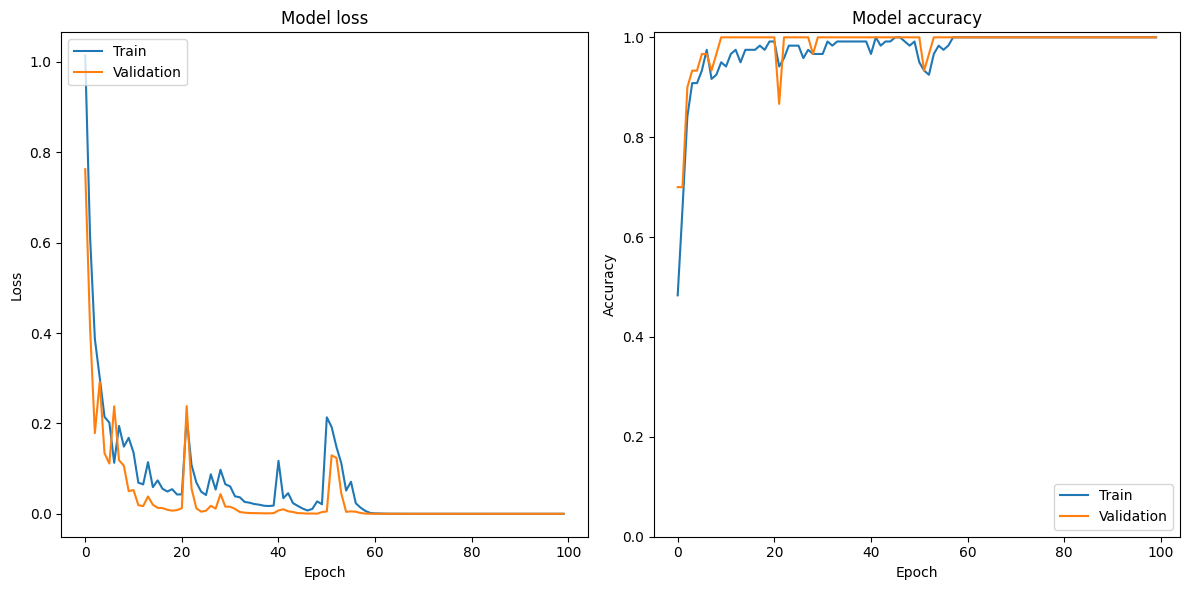

In [ ]:
# Define the neural network (same architecture as before).
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(4,)))
for i in range(8):
  model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

Training has gone better, although there is still some instability in the shape of the loss curve (especially on the training set; on the validation set in such a small dataset this could be an artifact of sampling). If we tweak the learning rate a bit and use a more sophisticated activation function with smoother behavior in its derivative "elu") we can get a much smoother loss curve (especially in the case of the training dataset).

With good activation functions and optimizers, we have managed to train this ridiculously complex (for the problem at hand) neural network.


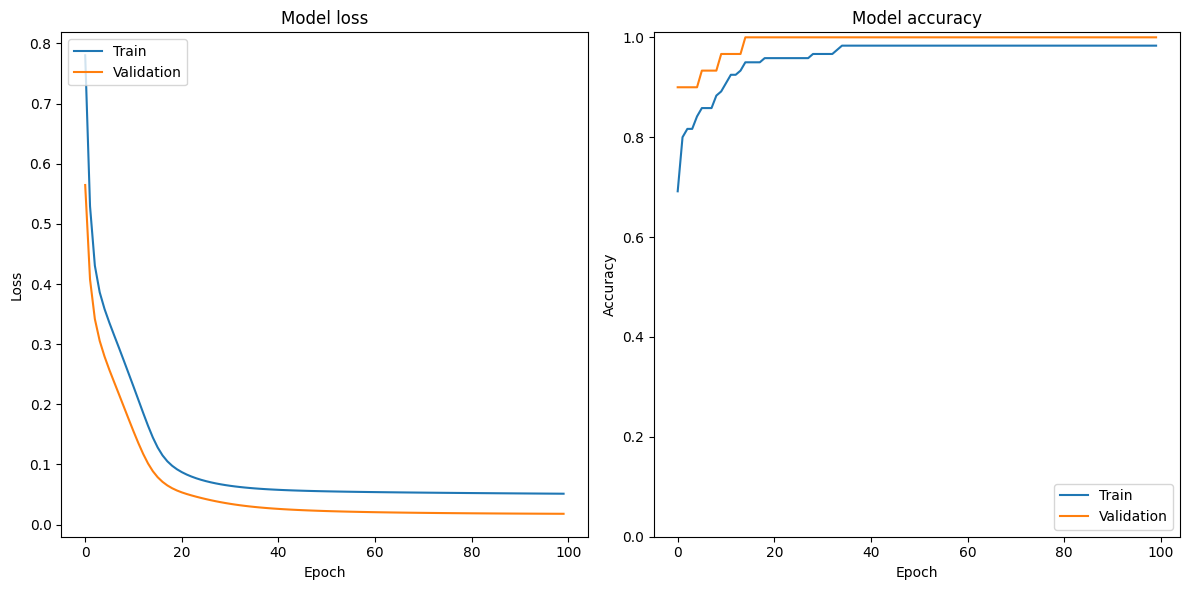

In [ ]:
# Define the neural network (same architecture as before)
model = Sequential()
model.add(Dense(100, activation='elu', input_shape=(4,)))
for i in range(8):
  model.add(Dense(100, activation='elu'))
model.add(Dense(3, activation='softmax'))  # 3 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

# The importance of weigth initialization

We are going to train a fairly deep network (30 hidden layers) on the iris dataset. When training deep networks, the strategy used to initialize the weights can have a high impact on the training result. In the following code, we will use the strategy that was typically used in the early 21st century of using a normal distribution with mean 0; the standard deviation will be 0.1 (instead of 1) since if we use a larger deviation (you can try changing it) the gradients will explode and the network weights will become NaN.

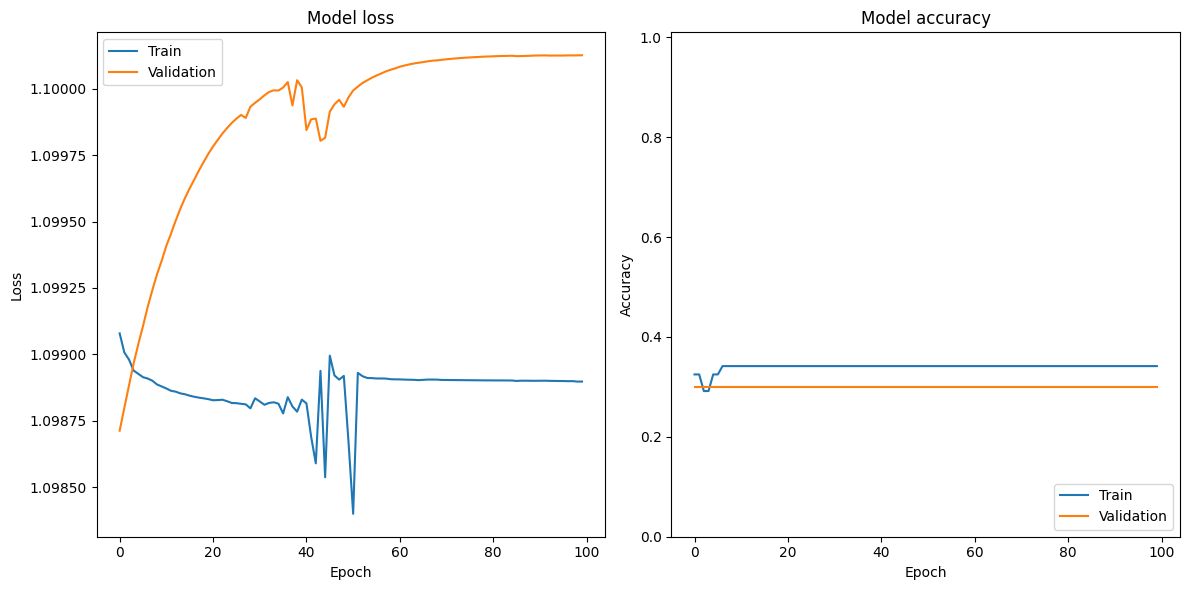

In [ ]:
import tensorflow as tf

# Improper initialization of weights: normal with high standard deviation
def bad_weight_init(shape, dtype=None):
    return np.random.normal(loc=0.0, scale=0.1, size=shape)

tf.random.set_seed(42)
# Define the neural network (same architecture as before)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(4,), kernel_initializer=bad_weight_init))
for i in range(30):
  model.add(Dense(100, activation='relu', kernel_initializer=bad_weight_init))
model.add(Dense(3, activation='softmax'))  # 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

You can see that the network has learned nothing. We will now use the default Keras initializer (Glorot) which is suitable for the hyperbolic tangent or logistic function, but not for Relu:

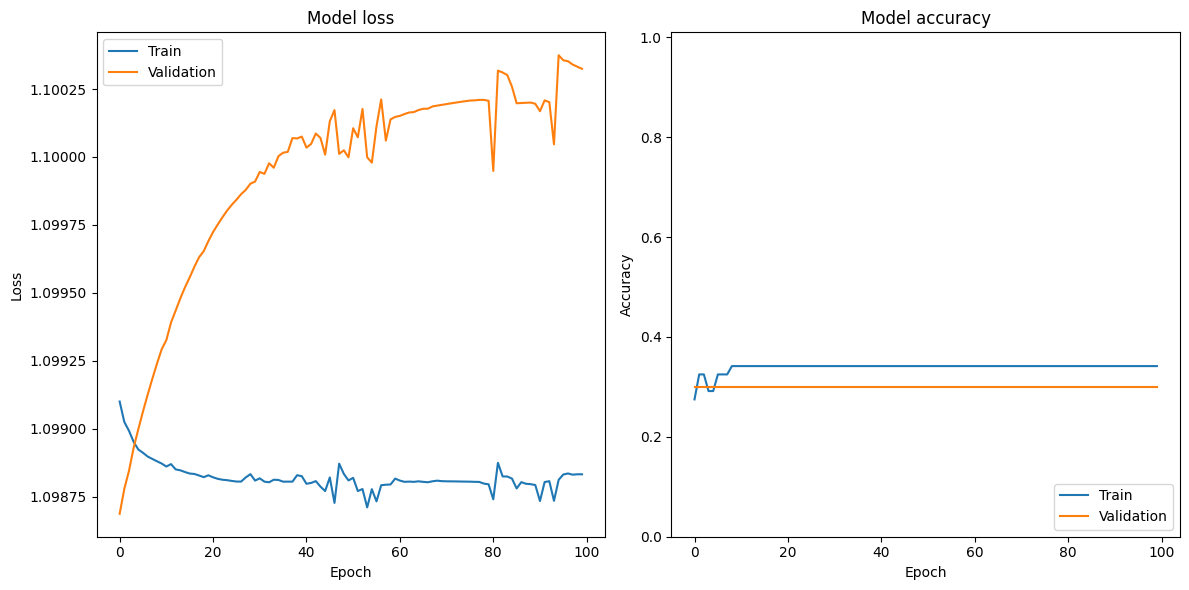

In [ ]:
tf.random.set_seed(42)

# Define the neural network (same architecture as before)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(4,)))
for i in range(30):
  model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

The results are better, but not excessively good either. Now let's use the most suitable initialization for Relu: He.

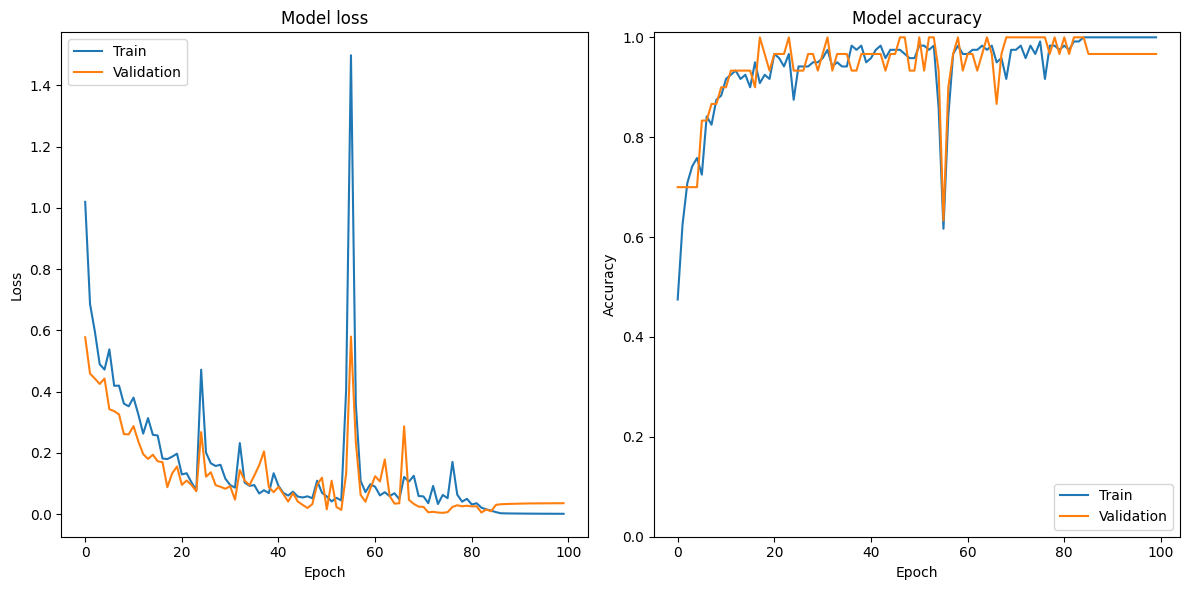

In [ ]:
tf.random.set_seed(42)
# Define the neural network (same architecture as before)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(4,), kernel_initializer='he_normal'))
for i in range(30):
  model.add(Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='softmax'))  # 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


The results are now considerably better, although there is still a lot of instability (abrupt behavior in the loss curves). It is complicated to train such a deep network.

## Explosion of gradients

Using inappropriate initialization weights can also cause the gradients of the network to explode. The following code initializes the weights with a normal distribution with variance 0.6. The network has 6 layers with 100 neurons in each layer. We will display the average value of the weights of each layer after each batch; each batch will have a size equal to the full data set.

In [ ]:
import tensorflow as tf

import random
import numpy as np
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Calulate the average weights of each layer
def average_weights_per_layer(model):
  """
  Calculates and prints the average weights for each layer of a Keras model.

  Args:
    model: The Keras model.
  """
  for i, layer in enumerate(model.layers):
    if isinstance(layer, Dense):  # Check if it's a Dense layer
      weights = layer.get_weights()[0] # Get weights (excluding biases)
      average_weight = np.mean(weights)
      print(f"Layer {i}: Average weight = {average_weight}")

# Improper initialization of weights: normal with high standard deviation
def bad_weight_init(shape, dtype=None):
    return np.random.normal(loc=0.0, scale=0.6, size=shape)

tf.random.set_seed(42)

# 6 layers
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(4,), kernel_initializer=bad_weight_init))
for i in range(5):
  model.add(Dense(100, activation='relu', kernel_initializer=bad_weight_init))
model.add(Dense(3, activation='softmax'))  # 3 output neurons for the 3 classes of Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

average_weights_per_layer(model)
# Train
history = model.fit(X_train, y_train, epochs=1, batch_size=120, validation_data=(X_test, y_test), verbose=1)
average_weights_per_layer(model)
# Train; If we call train again, the training continues where we left off
history = model.fit(X_train, y_train, epochs=1, batch_size=120, validation_data=(X_test, y_test), verbose=1)
average_weights_per_layer(model)
# Train
history = model.fit(X_train, y_train, epochs=1, batch_size=120, validation_data=(X_test, y_test), verbose=1)
average_weights_per_layer(model)
# Train
history = model.fit(X_train, y_train, epochs=1, batch_size=120, validation_data=(X_test, y_test), verbose=1)
average_weights_per_layer(model)
# Train
history = model.fit(X_train, y_train, epochs=1, batch_size=120, validation_data=(X_test, y_test), verbose=1)


Layer 0: Average weight = 0.013529165647923946
Layer 1: Average weight = -0.0019717037212103605
Layer 2: Average weight = 0.007348444312810898
Layer 3: Average weight = -0.006016832310706377
Layer 4: Average weight = -0.0058756940998137
Layer 5: Average weight = 0.004782242700457573
Layer 6: Average weight = -0.0033457335084676743
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3333 - loss: 1718.7460 - val_accuracy: 0.3667 - val_loss: 527798.8125
Layer 0: Average weight = -0.043823424726724625
Layer 1: Average weight = -0.01494093332439661
Layer 2: Average weight = -0.004873592406511307
Layer 3: Average weight = -0.022882472723722458
Layer 4: Average weight = -0.018112260848283768
Layer 5: Average weight = -0.010076090693473816
Layer 6: Average weight = -0.003345732344314456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3250 - loss: 595363.2500 - val_accuracy: 0.3000 - val_loss: 21754430881792.0000
Layer 0: Average weight = 21.952110290527344
Layer 1: Average weight = -5.325334